This is from Chris Revell's question on the Julia slack

In [159]:
using DifferentialEquations
using Distributions
using Turing
using DataFrames
using Plots

In [181]:
# Constant accelerating particle. What could be easier?
function fAcceleration(du, u, p, t) 
    du[1] = u[2]
    du[2] = p[1] 
    return nothing
end
##
# Dummy data created by adding noise to a previous solution 
odeProblem = ODEProblem(fAcceleration,[0.0,0.0],(0.0,10.0),[2.0])
sol = solve(odeProblem,Rosenbrock23(), saveat=0.1, p=[2.0])
dummyData = first.(sol.u).+ rand(Normal(0,5),101)
##

101-element Vector{Float64}:
  -6.149750185234256
  -0.8796804232712895
  -5.1800749510928705
   6.764135797365245
 -10.211443432913022
  -8.672007695244176
  -5.497203735457849
  -4.687227412676299
  -1.39403654574649
   0.9438948751883316
   ⋮
  83.94580852318065
  87.33471701482976
  90.68879936826285
  94.47648794643449
  89.9268879165618
  90.3639973959235
  92.67227295330592
  98.25317122079637
 100.77409774980208

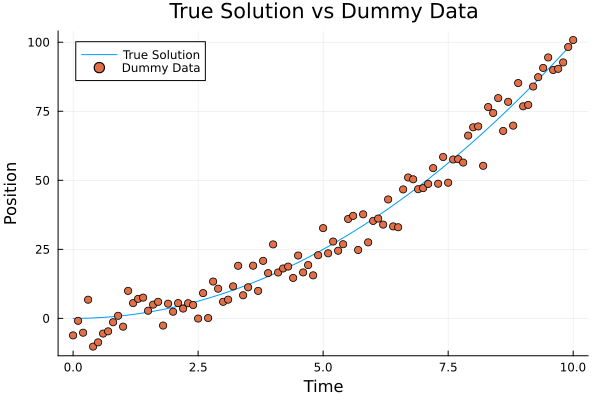

In [182]:
plot(sol.t,first.(sol.u),label="True Solution",xlabel="Time",ylabel="Position",title="True Solution vs Dummy Data")
plot!(sol.t,dummyData,label="Dummy Data",seriestype=:scatter)

In [183]:
@model function fitmodel(data, prob)
    # Prior
    σ ~ InverseGamma(1, 50)
    a ~ Normal(1.5,2.0)
    # Likelihood

    p = [a]
    prob = remake(prob,p=p)
    #sol = solve(prob,Rosenbrock23(), saveat=0.1)
    sol = solve(prob, saveat=0.1)
    predicted = first.(sol.u)
 
    for i = 1:length(predicted)
        data[i] ~ Normal(predicted[i], σ)
    end
    return nothing
end

fitmodel (generic function with 4 methods)

In [173]:
first.(sol.u)[1]

0.0

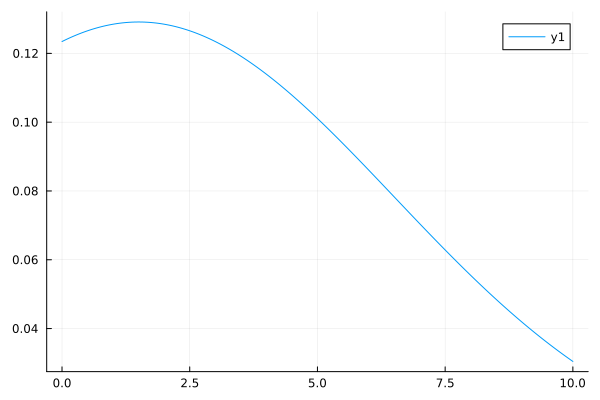

In [165]:
 
plot(0:0.01:10, pdf.(truncated(Normal(1.5,5.0),lower=0),0:0.01:10))

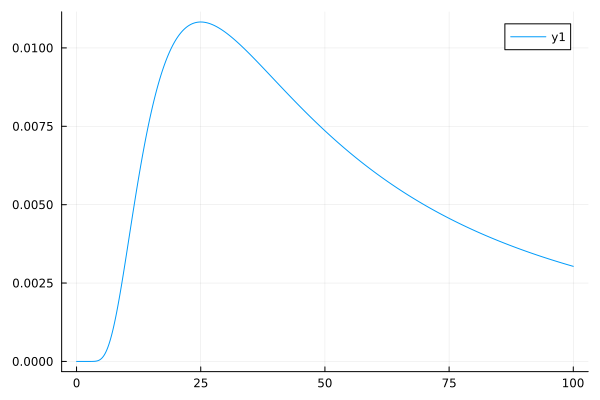

In [166]:
#plot the inverse gamma
plot(0:0.01:100, pdf.(InverseGamma(1,50),0:0.01:100))

In [184]:

model = fitmodel(dummyData, odeProblem)

DynamicPPL.Model{typeof(fitmodel), (:data, :prob), (), (), Tuple{Vector{Float64}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(fAcceleration), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}}, Tuple{}, DynamicPPL.DefaultContext}(fitmodel, (data = [-6.149750185234256, -0.8796804232712895, -5.1800749510928705, 6.764135797365245, -10.211443432913022, -8.672007695244176, -5.497203735457849, -4.687227412676299, -1.39403654574649, 0.9438948751883316  …  77.30037056089408, 83.94580852318065, 87.33471701482976, 90.68879936826285, 94.47648794643449, 89.9268879165618, 90.3639973959235, 92.67227295330592, 98.25317122079637, 100.77409774980208], prob = ODEProblem{Vecto

In [185]:
# Sampling 
chain = sample(model, NUTS(1000,.85), MCMCSerial(), 1000, 3);

##

Chains MCMC chain (1000×14×3 Array{Float64, 3}):

Iterations        = 1001:1:2000
Number of chains  = 3
Samples per chain = 1000
Wall duration     = 16.89 seconds
Compute duration  = 16.86 seconds
parameters        = σ, a
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           σ    5.1034    0.3584     0.0065    0.0074   1882.7853    0.9993    ⋯
           a    1.9885    0.0223     0.0004    0.0005   2311.4284    0.9999    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

        

In [186]:
chainDF = DataFrame(chain);

In [189]:
odeProblem = ODEProblem(fAcceleration,[0.0,0.0],(0.0,10.0),[mean(chainDF[!,:a])])
sol2 = solve(odeProblem, saveat=0.1);

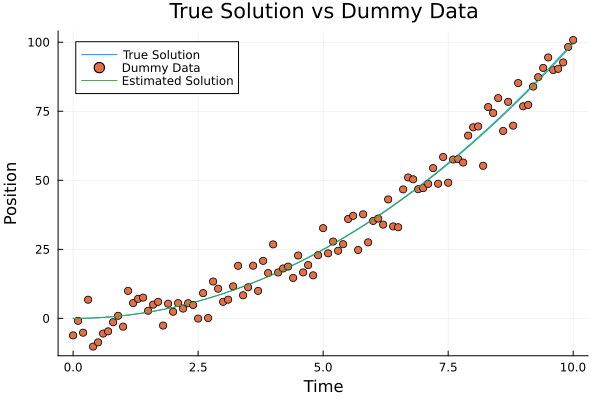

In [190]:
plot(sol.t,first.(sol.u),label="True Solution",xlabel="Time",ylabel="Position",title="True Solution vs Dummy Data")
plot!(sol.t,dummyData,label="Dummy Data",seriestype=:scatter)
plot!(sol2.t,first.(sol2.u),label="Estimated Solution")

In [191]:
chain

Chains MCMC chain (1000×14×3 Array{Float64, 3}):

Iterations        = 1001:1:2000
Number of chains  = 3
Samples per chain = 1000
Wall duration     = 16.89 seconds
Compute duration  = 16.86 seconds
parameters        = σ, a
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           σ    5.1034    0.3584     0.0065    0.0074   1882.7853    0.9993    ⋯
           a    1.9885    0.0223     0.0004    0.0005   2311.4284    0.9999    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

        